# Collaborator 3 – Normalization & Correlation

Goal: Prepare features for stable and interpretable modeling.

Input:
* Original DataFrame from Collaborator 2

Tasks:
* Normalize numerical variables (z-score or min-max).
* Compute correlation matrix.
* Identify highly correlated features (e.g., sysBP vs diaBP).
* Propose which features to keep or remove.
* Finalize clean feature list.

Deliverables:
* Normalized dataset
* Correlation analysis summary
* Final feature set recommendation

---
### 1. Data context and column grouping

Before applying any transformation, it is essential to define the types of variables in the DataFrame.  
This allows us to decide which columns should be normalized and which should not:

- **Continuous:** numerical variables with a wide range (age, blood pressure, cholesterol, glucose, etc.).  
- **Binary:** categorical variables encoded as 0/1 (sex, smoker, hypertension, diabetes, etc.).  
- **Ordinal:** variables with ordered categories (education level).  

In addition, we will work on a **copy of the DataFrame** (`df_work`) to avoid modifying the original dataset from Collaborator 2.  
This step ensures reproducibility and prevents errors if we need to return to the initial state.


In [ ]:
import pandas as pd

# 1. Load the engineered dataset from collaborator 2
df = pd.read_csv("engineered_df.csv")

# 2. Copy of work to avoid modifying the original df
df_work = df.copy()

# 3. Define feature groups
num_cols = [
    "age", "bmi", "systolic_bp", "diastolic_bp", "total_cholesterol",
    "glucose", "heart_rate", "cigs_per_day", "pulse_pressure", "smoker_intensity"
]

binary_cols = [
    "sex", "current_smoker", "bp_meds",
    "prevalent_stroke", "prevalent_hypertension", "diabetes"
]

ordinal_cols = ["education_level"]

target_col = "ten_year_chd"

# 4. First check: verify that all expected columns exist
expected_cols = set(num_cols + binary_cols + ordinal_cols + [target_col])
missing_cols = expected_cols - set(df_work.columns)
assert len(missing_cols) == 0, f"Missing columns: {missing_cols}"

# 5. Second check: ensure numerical columns are numeric
df_work[num_cols] = df_work[num_cols].apply(pd.to_numeric, errors="coerce")

# 6. Third check: check for missing values before normalization
df_work[num_cols].isna().sum()

age                  0
bmi                  0
systolic_bp          0
diastolic_bp         0
total_cholesterol    0
glucose              0
heart_rate           0
cigs_per_day         0
pulse_pressure       0
smoker_intensity     0
dtype: int64

#### **Feedback of the output:**
No missing values were found in the numerical variables, so the dataset is ready for normalization.


---
### 2. Normalization of continuous variables

To ensure comparability across features and avoid scale dominance, we normalize all continuous variables.  
We apply **z-score normalization (mean = 0, standard deviation = 1)** to continuous columns.  
Binary and ordinal variables remain unchanged to preserve their categorical meaning.


#### **Why we use z-score normalization**

Using z-score normalization is appropriate here because:

- **It prevents scale dominance:** clinical variables such as cholesterol, glucose, BMI or blood pressure operate on very different numeric ranges. Standardization ensures that no variable disproportionately influences correlations or downstream models simply due to its scale.
- **It improves numerical stability:** many algorithms (e.g., logistic regression, SVMs, k-NN, neural networks) perform better when features are centered and scaled.
- **It preserves distribution shape:** unlike min–max scaling, z-score does not compress values into a fixed interval, keeping outliers and variability clinically interpretable.
- **It aligns with clinical reasoning:** expressing values in terms of “how many standard deviations from the mean” is intuitive and consistent with clinical thresholds (e.g., unusually high glucose or blood pressure).

Binary and ordinal variables are left unchanged because scaling them would remove their categorical meaning.

In [2]:
# First we will check the summary of continuous variables before normalization
df_work[num_cols].describe().round(2)


,age,bmi,systolic_bp,diastolic_bp,total_cholesterol,glucose,heart_rate,cigs_per_day,pulse_pressure,smoker_intensity
count,3656.00,3656.00,3656.00,3656.00,3656.00,3656.00,3656.00,3656.00,3656.00,3656.00
mean,49.56,25.78,132.37,82.91,236.87,81.86,75.73,9.02,49.46,9.02
std,8.56,4.07,22.09,11.97,44.10,23.91,11.98,11.92,14.67,11.92
min,32.00,15.54,83.50,48.00,113.00,40.00,44.00,0.00,15.00,0.00
25%,42.00,23.08,117.00,75.00,206.00,71.00,68.00,0.00,40.00,0.00
50%,49.00,25.38,128.00,82.00,234.00,78.00,75.00,0.00,47.00,0.00
75%,56.00,28.04,144.00,90.00,263.25,87.00,82.00,20.00,56.00,20.00
max,70.00,56.80,295.00,142.50,600.00,394.00,143.00,70.00,160.00,70.00


In [3]:
# We apply z-score normalization to all continuous variables to ensure they share a comparable scale before correlation analysis and modeling.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_work[num_cols] = scaler.fit_transform(df_work[num_cols])

# Quick check: mean ~0, std ~1 after normalization
df_work[num_cols].agg(["mean", "std"]).round(2)


,age,bmi,systolic_bp,diastolic_bp,total_cholesterol,glucose,heart_rate,cigs_per_day,pulse_pressure,smoker_intensity
mean,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### **Feedback on normalization output**

After applying **StandardScaler** to the continuous variables, we verified the transformation by checking the post-normalization means and standard deviations.  
All continuous features now show **mean ≈ 0** and **standard deviation ≈ 1**, confirming that the z-score normalization was applied correctly and that the variables are now on a comparable scale.


#### **What is StandardScaler?**

`StandardScaler` is a preprocessing tool from **scikit-learn** that applies **z-score normalization** to numerical variables.  
Each value **x** is transformed as:

**z=(x-mu)/sigma**


where **mu** is the mean and **sigma** is the standard deviation of the variable.

#### **Why use it?**
- **Comparability**: puts all continuous variables on the same scale.  
- **Model stability**: many algorithms (logistic regression, SVM, PCA, neural networks) perform better when inputs are standardized.  
- **Interpretability**: values represent how many standard deviations a data point is above or below the mean.  
- **Avoid dominance**: prevents variables with large ranges (e.g., cholesterol in mg/dL) from overshadowing smaller-scale variables (e.g., BMI).

In summary, StandardScaler ensures that continuous features contribute equally to the model and improves both interpretability and performance.


---
### 3. Correlation analysis

After normalization, we compute the correlation matrix to identify relationships between variables.  
This step helps us detect redundant features that carry overlapping information.  
We will focus on pairs with correlation coefficients |r| ≥ 0.8, as these indicate strong linear dependence.  
Highly correlated features may be candidates for removal to improve model stability and interpretability.


##### **Clinical note on correlation threshold (≥ 0.8)**

In clinical data analysis, a correlation coefficient |r| ≥ 0.8 is considered very strong.  
This means two variables move almost together, often reflecting overlapping physiological information.  
For example, **systolic and diastolic blood pressure** are highly correlated because both measure arterial pressure.  
Keeping both in a model may add redundancy without improving predictive power.  
Therefore, we mark pairs with |r| ≥ 0.8 as candidates for reduction, keeping the variable with clearer clinical meaning.


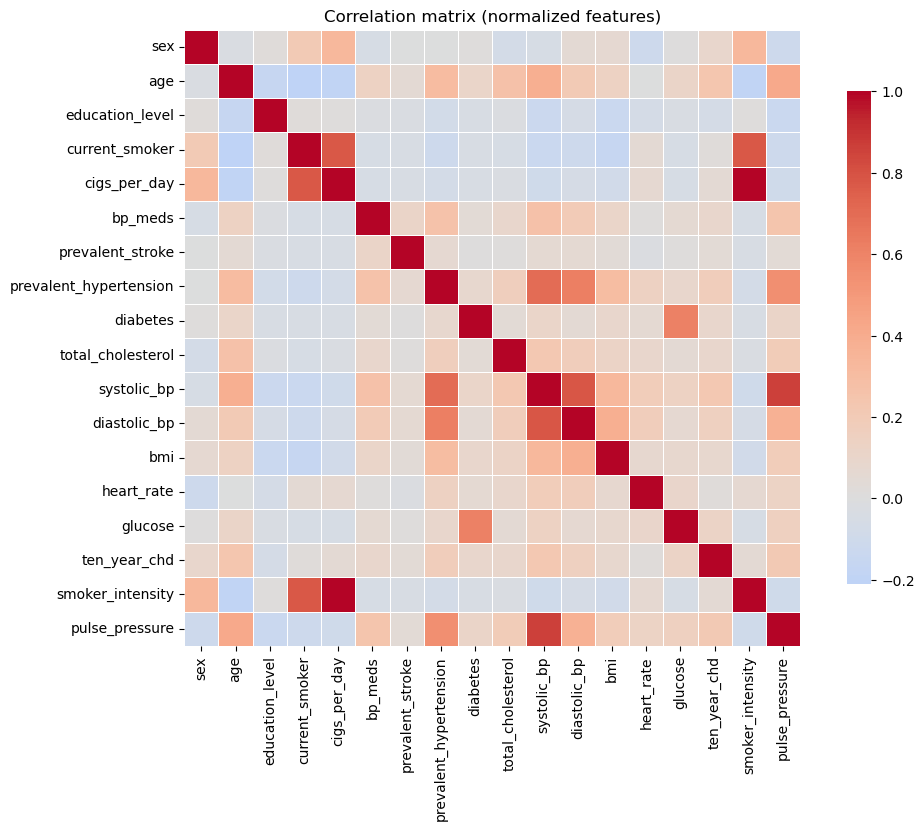

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute correlation matrix
corr = df_work.corr()

# 2. Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation matrix (normalized features)")
plt.show()


In [5]:
# Extract highly correlated pairs (|r| ≥ 0.8), excluding self-correlations
threshold = 0.8
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

high_corr_pairs = (
    upper.stack()
         .rename("r")
         .reset_index()
         .sort_values("r", ascending=False)
)

high_corr_pairs = high_corr_pairs[high_corr_pairs["r"].abs() >= threshold]

high_corr_pairs


,level_0,level_1,r
73,cigs_per_day,smoker_intensity,1.000000
131,systolic_bp,pulse_pressure,0.863769


#### **Feedback on correlation outputs**

After computing the correlation matrix, we identified two pairs of variables with very strong linear relationships (|r| ≥ 0.8):

- **cigs_per_day vs smoker_intensity**:  r = 1.00  
  This is expected, as `smoker_intensity` is a derived feature:  
  

  *smoker_intensity = current_smoker × cigs_per_day*

  
  Since `current_smoker` is binary (0 or 1), `smoker_intensity` is a masked version of `cigs_per_day`.  
  → We will **keep `smoker_intensity`** and **drop `cigs_per_day`**, as the derived feature captures exposure more meaningfully.

- **systolic_bp vs pulse_pressure**: r ≈ 0.86  
  This reflects physiological overlap: `pulse_pressure` is defined as:  
  

  *pulse_pressure = systolic_bp – diastolic_bp*

  
  Despite the correlation, both variables may carry complementary clinical information.  
  → We will **keep both** for now, pending model performance evaluation.

These decisions aim to reduce redundancy while preserving interpretability and clinical relevance.


---
### 4. Feature selection and dataset export

Based on the correlation analysis, we decided to remove redundant variables:

- **Drop `cigs_per_day`** → fully captured by `smoker_intensity`.  
- **Keep both `systolic_bp` and `pulse_pressure`** → despite their correlation, they provide complementary clinical information.  

This step reduces redundancy while preserving interpretability and clinical relevance.  
Finally, we export the cleaned dataset for downstream modeling and analysis.


In [6]:
# First we remove redundant features to reduce multicollinearity and simplify the model.
#--------------------------------------------------------------------------------------------
# Feature selection: drop redundant variable
cleaned_df = df_work.drop(columns=["cigs_per_day"])

# Quick check: confirm column removal
assert "cigs_per_day" not in cleaned_df.columns

# Showing final shape and columns
print("Cleaned dataset shape:", cleaned_df.shape)
print("Final columns:", cleaned_df.columns.tolist())



Cleaned dataset shape: (3656, 17)
Final columns: ['sex', 'age', 'education_level', 'current_smoker', 'bp_meds', 'prevalent_stroke', 'prevalent_hypertension', 'diabetes', 'total_cholesterol', 'systolic_bp', 'diastolic_bp', 'bmi', 'heart_rate', 'glucose', 'ten_year_chd', 'smoker_intensity', 'pulse_pressure']


In [7]:
# Second we document which features were removed to ensure full transparency in the selection process.
removed = set(df_work.columns) - set(cleaned_df.columns)
print("Removed features:", removed)


Removed features: {'cigs_per_day'}


In [8]:
# Third we store the final feature list to define the input matrix for modeling.
final_features = cleaned_df.columns.tolist()
final_features


['sex',
 'age',
 'education_level',
 'current_smoker',
 'bp_meds',
 'prevalent_stroke',
 'prevalent_hypertension',
 'diabetes',
 'total_cholesterol',
 'systolic_bp',
 'diastolic_bp',
 'bmi',
 'heart_rate',
 'glucose',
 'ten_year_chd',
 'smoker_intensity',
 'pulse_pressure']

In [9]:
# Finally we check that only one strong correlation remains (systolic_bp & blood_pressure)
# This is expected and justified, so both variables are retained.
#--------------------------------------------------------------------------------
corr_final = cleaned_df.corr()
upper_final = corr_final.where(np.triu(np.ones(corr_final.shape), k=1).astype(bool))

# Stack first, then filter
high_corr_final = (
    upper_final
        .stack()
        .rename("r")
        .reset_index()
        .query("abs(r) >= 0.8")
        .sort_values("r", ascending=False)
)

high_corr_final



,level_0,level_1,r
114,systolic_bp,pulse_pressure,0.863769


In [10]:
# Export the final feature‑engineered, normalized, and de‑redundant dataset
cleaned_df.to_csv("cleaned_df.csv", index=False)

#### **Feedback on the final cleaned dataset**

##### **Dataset dimensions**

**Cleaned dataset shape: (3656, 17)**  
The final dataset preserves all **3656 original observations**, confirming that the cleaning and feature‑selection steps did not remove any rows or introduce data loss.  
The final count of **17 variables** reflects the correct removal of the single redundant feature (`cigs_per_day`).



##### **Final variables included**

The dataset now contains the following columns:

- **Demographic variables:**  
  `sex`, `age`, `education_level`

- **Lifestyle factors:**  
  `current_smoker`, `smoker_intensity`

- **Clinical variables:**  
  `bp_meds`, `prevalent_stroke`, `prevalent_hypertension`, `diabetes`,  
  `total_cholesterol`, `systolic_bp`, `diastolic_bp`,  
  `bmi`, `heart_rate`, `glucose`, `pulse_pressure`

- **Target variable:**  
  `ten_year_chd`

These 17 features match exactly the final feature list extracted from the cleaned dataset.



##### **Interpretation**

- The removal of `cigs_per_day` is fully justified, as its information is already captured by the more informative feature `smoker_intensity`.  
- A final correlation check shows that only one strong correlation remains:  
  **systolic_bp ↔ pulse_pressure (r = 0.86)**.  
  This relationship is clinically expected, since pulse pressure is derived from systolic and diastolic blood pressure.  
  Both variables are retained because they provide **complementary and clinically meaningful information**.
- The final dataset is **clean, normalized, and minimally redundant**, ensuring a stable and interpretable foundation for downstream modeling.





---
### Summary - Normalization & Correlation

The continuous variables were standardized using z‑score normalization to ensure that all features operated on a comparable scale (mean ≈ 0, standard deviation ≈ 1). This step stabilizes distance‑based relationships, prevents scale‑driven dominance in correlation analysis, and prepares the dataset for interpretable modeling. A pre‑normalization summary confirmed the heterogeneity of the original scales, while post‑normalization checks validated that the transformation was applied correctly across all numerical variables.

A full correlation matrix and heatmap were computed to identify linear dependencies between predictors. Several moderate correlations were observed, and one strong relationship emerged between systolic blood pressure and pulse pressure (r = 0.86). This association is clinically expected, as pulse pressure is derived from systolic and diastolic blood pressure. Beyond this physiological dependency, no additional pairs exceeded the high‑correlation threshold (|r| ≥ 0.8), indicating limited multicollinearity in the dataset.

Feature selection focused on removing redundant or overlapping predictors while preserving clinically meaningful information. The variable *cigs_per_day* was dropped because its information was fully captured by the engineered feature *smoker_intensity*, which better represents smoking exposure. All remaining variables were retained, including both systolic blood pressure and pulse pressure, as they provide complementary insights into cardiovascular physiology. The final cleaned dataset contains 17 well‑defined features, free from unnecessary redundancy and ready for downstream modeling.

Overall, this section delivers a normalized dataset, a clear correlation analysis, and a transparent, clinically grounded feature‑selection process that ensures stability, interpretability, and reproducibility for subsequent modeling steps.
